In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine,reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
station_data = session.query(Station.station, Station.name).all()
station_data

[('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

In [10]:
session.query(func.min(Measurement.date)).all()

[('2010-01-01',)]

In [11]:
# Find the most recent date in the data set.
last_date = session.query(func.max(Measurement.date)).all()
last_date = list(np.ravel(last_date))[0]
last_date

'2017-08-23'

In [12]:
last_date=dt.datetime.strptime(last_date,'%Y-%m-%d')
last_year=int(dt.datetime.strftime(last_date,'%Y'))
last_month=int(dt.datetime.strftime(last_date,'%m'))
last_day=int(dt.datetime.strftime(last_date,'%d'))
print(last_year, last_month, last_day)

2017 8 23


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
prior_year_date = dt.date(last_year,last_month,last_day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
annual_prec = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= prior_year_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
annual_prec_df = pd.DataFrame(annual_prec, columns=['Date', 'Precipitation'])


annual_prec_df.sort_values('Date',inplace=True)
annual_prec_df = annual_prec_df.set_index('Date')
annual_prec_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


<function matplotlib.pyplot.show(close=None, block=None)>

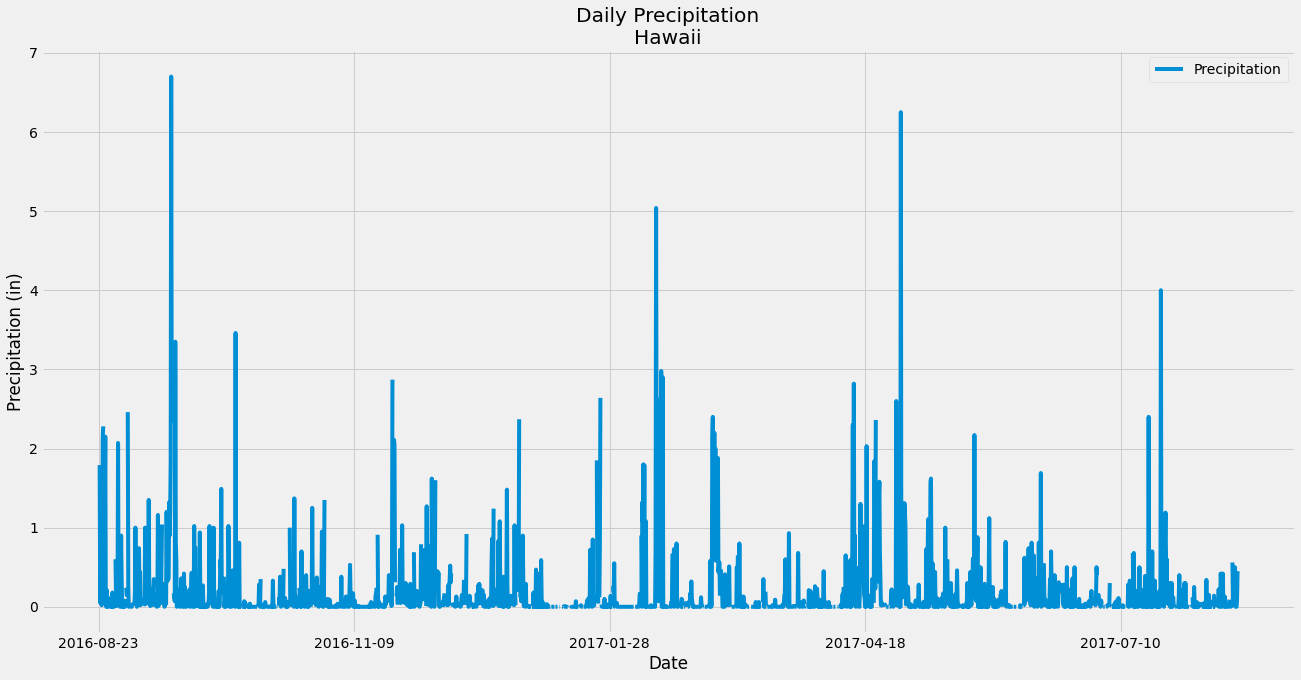

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
annual_prec_df.plot(title = 'Daily Precipitation\nHawaii', xlabel = 'Date', ylabel='Precipitation (in)',figsize=(20,10))
plt.legend(loc='upper right')
plt.show


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
annual_prec_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement.station).distinct().count()

9

In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
top_station = active_stations[0][0]
top_station_info = session.query(Station.name).filter(Station.station == top_station).all()
station_name =top_station_info[0][0]
Min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == top_station).first()
Max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == top_station).first()
Ave_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == top_station).first()
 
print(f"Most active station is ID # {top_station}: {station_name} \nLowest Temp: {Min_temp} \nHighest Temp: {Max_temp} \nAverage Temp: {Ave_temp}")

Most active station is ID # USC00519281: WAIHEE 837.5, HI US 
Lowest Temp: (54.0,) 
Highest Temp: (85.0,) 
Average Temp: (71.66378066378067,)


In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_top_station = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == top_station).\
    filter(Measurement.date>prior_year_date).all()
top_station_temps = pd.DataFrame(temp_top_station,columns=['Date','Temperature'])
top_station_temps.set_index('Date', inplace=True)
top_station_temps

,Temperature
Date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


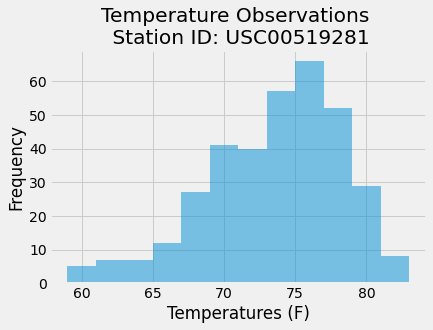

In [20]:
x = top_station_temps['Temperature']
plt.hist(x, alpha=0.5, bins=12)
plt.xlabel('Temperatures (F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations \n Station ID: USC00519281')
plt.show()


# Close session

In [ ]:
# Close Session
session.close()